In [ ]:
import torch
import torch.nn as nn

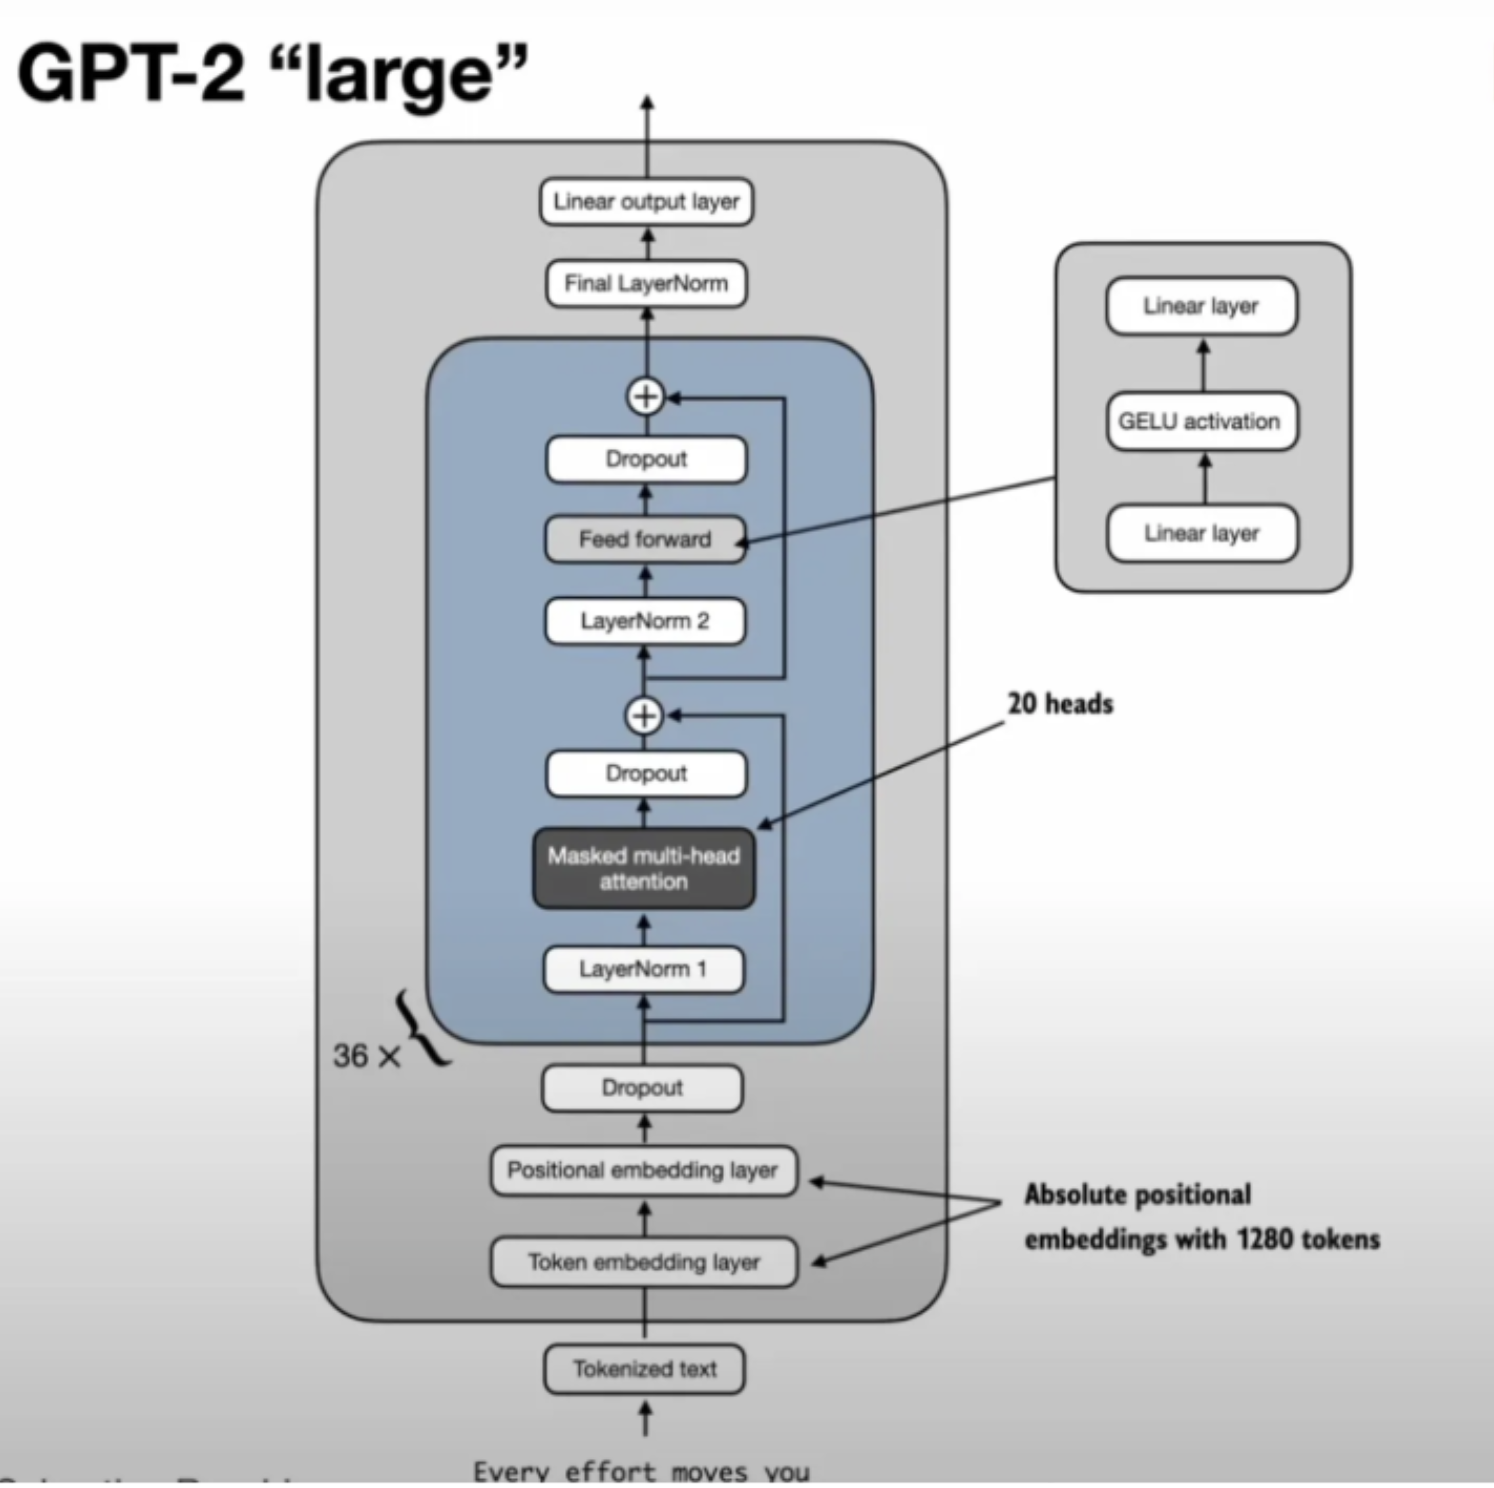

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim)) #trainable parameters
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

Causal Mask for Self-Attention
The following PyTorch code creates a causal mask for a transformer model’s self-attention mechanism:
self.register_buffer(
    "mask",
    torch.triu(torch.ones(context_length, context_length), diagonal=1)
)

Explanation

Purpose: Creates a causal mask to ensure tokens in a sequence only attend to themselves and previous tokens during self-attention, critical for autoregressive models like GPT.
self.register_buffer:
Registers a tensor (mask) as a non-trainable buffer in the model.
Buffers are stored in the model’s state, move with the model to devices (e.g., GPU), and are saved/loaded with the model, but are not updated during training.
Used for fixed tensors like masks or positional encodings.


torch.ones(context_length, context_length): Creates a square tensor of shape (context_length, context_length) filled with ones.
torch.triu(..., diagonal=1): Extracts the upper triangular part of the tensor, setting elements below the first upper diagonal to zero:
diagonal=1 includes the diagonal above the main diagonal, creating a mask where:
0: Allows attention (current and previous tokens).
1: Blocks attention (future tokens).


Example for context_length = 4:$$\begin{bmatrix}0 & 1 & 1 & 1 \0 & 0 & 1 & 1 \0 & 0 & 0 & 1 \0 & 0 & 0 & 0\end{bmatrix}$$


Usage: The mask is applied to attention scores (e.g., setting future token scores to -inf before softmax) to enforce causality.

Why It Matters

Ensures autoregressive behavior by preventing attention to future tokens.
register_buffer makes the mask a persistent, device-compatible part of the model.


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(  #non trainable buffer
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape   #emb_dim ==d_in==d_out

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, self.num_heads,  num_tokens,self.head_dim)    #(b, num_heads, num_tokens, head_dim)
        values = values.view(b, self.num_heads,  num_tokens,self.head_dim)
        queries = queries.view(b, self.num_heads,  num_tokens,self.head_dim)

        attn_scores = queries @ keys.transpose(2, 3)  #(b, num_heads, num_tokens, num_tokens)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) #transpose is done cause To merge in next step, you need tokens (T) before the flattened head dimension.

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) #The .contiguous() method in the provided PyTorch code snippet is used to ensure that the tensor context_vec is stored in a contiguous block of memory before reshaping it
        context_vec = self.out_proj(context_vec)

        return context_vec

transformer block

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attn=MultiHeadAttention(cfg["emb_dim"], cfg["emb_dim"], cfg["context_length"], cfg["drop_rate"], cfg["n_heads"], cfg["qkv_bias"])
    self.ff=FeedForward(cfg)
    self.dropout=nn.Dropout(cfg["drop_rate"])
    self.norm1=LayerNorm(cfg["emb_dim"])
    self.norm2=LayerNorm(cfg["emb_dim"])

  def forward(self, x):
    # Shortcut connection for attention block
    shortcut=x
    x=self.norm1(x)
    x=self.attn(x); # Shape [batch_size, num_tokens, emb_size]
    x=self.dropout(x);
    x=x+shortcut # Add the original input back

    # Shortcut connection for feed forward block
    shortcut=x
    x=self.norm2(x);
    x=self.ff(x)
    x=self.dropout(x);
    x=x+shortcut
    return x


# GPT Model Input Tensor

The main GPT model class receives input as a tensor with dimensions `(batch_size, context_length)`. Below is an example of the input tensor:

$$
\text{Input Tensor} = \begin{bmatrix}
6109 & 3626 & 6100 & 345 \\
6109 & 1110 & 6622 & 257
\end{bmatrix}
$$

### Description
- **Batch Size**: 2 (number of sequences)
- **Context Length**: 4 (length of each sequence)
- **Values**: Token IDs representing the input sequences for the GPT model.

This tensor is processed by the model to generate predictions or embeddings based on the provided context.

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb=nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb=nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb=nn.Dropout(cfg["drop_rate"])
    self.trf_blocks=nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm=LayerNorm(cfg["emb_dim"])
    self.out_head=nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, x):
    B, T=x.shape  #batch_size, context_length
    tok_emb=self.token_emb(x) # outputs (batch_size, context_length, emb_dim)
    pos_emb=self.pos_emb(torch.arange(T, device=x.device)) #his line performs positional embedding.
    #It creates a tensor of integers from 0 to T-1 (where T is the context length) using torch.arange(T).
    #This tensor represents the positions of the tokens in the sequence.
    #It then looks up the corresponding positional embedding vector for each position using the self.pos_emb layer (another nn.Embedding layer).
    #The device=x.device part ensures that the positional embeddings are created on the same device as the input tensor x. The result pos_emb is a tensor with shape (context_length, emb_dim).
    x=tok_emb+pos_emb
    x=self.drop_emb(x)
    x=self.trf_blocks(x)
    x=self.final_norm(x)
    logits=self.out_head(x)
    return logits


testing before training

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
model = GPTModel(GPT_CONFIG_124M).to(device)
batch = batch.to(device)
out=model(batch) #(2,4,50257)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]], device='cuda:0')

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.6922,  0.2634, -0.2849,  ..., -1.0773, -0.4309, -0.8916],
         [-0.6233, -0.1007, -0.0327,  ..., -0.0870,  0.1069, -0.5880],
         [-0.1118, -0.2850,  0.8336,  ...,  0.3913, -0.3194,  0.1059],
         [-0.4243, -0.2197, -0.2244,  ..., -0.4491,  0.5298,  0.5255]],

        [[-0.5528,  0.3892,  0.1120,  ..., -0.4466, -0.3899, -0.9814],
         [ 0.3527, -0.0715, -0.0127,  ..., -0.9236, -0.2503, -0.1283],
         [-0.7410,  0.0264, -0.4580,  ...,  0.7532,  0.2514, -0.1738],
         [ 0.2083,  0.1276,  0.3990,  ...,  0.5079,  0.3786,  0.9103]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)


implemention data loader


In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [ ]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


In [ ]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_text = text_data[:split_idx]
val_text = text_data[split_idx:]

In [ ]:
print(len(train_text))
print(train_text[:100])

18431
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [ ]:


train_loader = create_dataloader_v1(
    train_text,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_text,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize model
model = GPTModel(GPT_CONFIG_124M).to(device)

Using device: cuda


In [ ]:

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1)

In [ ]:

scaler = torch.amp.GradScaler("cuda") #mixed precision
# Validation loss helper
def evaluate_loss(dataloader):
    model.eval()
    total_loss, count = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast("cuda"):
                logits = model(x)  # [B, T, vocab_size]
                loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), y.flatten())
            total_loss += loss.item()
            count += 1
    model.train()
    return total_loss / count

# Training loop
def train_model(train_loader, val_loader, epochs=1, log_interval=5):
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast("cuda"):
                logits = model(x)
                loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), y.flatten())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if (batch_idx + 1) % log_interval == 0:
                val_loss = evaluate_loss(val_loader)
                print(f"Batch {batch_idx+1:4d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}")

In [ ]:
train_model(train_loader, val_loader, epochs=10, log_interval=5)


Epoch 1/10
Batch    5 | Train Loss: 9.1182 | Val Loss: 8.8026

Epoch 2/10
Batch    5 | Train Loss: 6.5101 | Val Loss: 6.9941

Epoch 3/10
Batch    5 | Train Loss: 5.6515 | Val Loss: 6.4780

Epoch 4/10
Batch    5 | Train Loss: 3.8068 | Val Loss: 6.2998

Epoch 5/10
Batch    5 | Train Loss: 3.0621 | Val Loss: 6.2882

Epoch 6/10
Batch    5 | Train Loss: 2.7016 | Val Loss: 6.2854

Epoch 7/10
Batch    5 | Train Loss: 1.3062 | Val Loss: 6.3621

Epoch 8/10
Batch    5 | Train Loss: 1.3738 | Val Loss: 6.4042

Epoch 9/10
Batch    5 | Train Loss: 0.7391 | Val Loss: 6.5038

Epoch 10/10
Batch    5 | Train Loss: 0.5063 | Val Loss: 6.5478


In [ ]:
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm()
      (norm2): LayerNorm()
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=7

Top K sampling with temperature controlling

In [ ]:
def generate(model, idx, max_new_tokens,context_size,temperature=0.0, top_k=None):

  for _ in range(max_new_tokens):
    idx_cond=idx[:,-context_size:]
    with torch.no_grad():
      logits=model(idx_cond)
    logits=logits[:,-1,:]

    #top k sampling
    if top_k is not None:
      top_logits,_=torch.topk(logits,top_k);
      min_val=top_logits[:,-1]
      logits=torch.where(logits<min_val, torch.tensor(float("-inf")).to(logits.device),logits)
    # temp scaling
    if temperature>0.0:
      logits=logits/temperature
      probs=torch.softmax(logits, dim=-1)
      idx_next=torch.multinomial(probs,num_samples=1) #(batch_size,1)

    idx=torch.cat((idx,idx_next),dim=1);
  return idx


In [ ]:
def decode_tokens(token_ids, tokenizer):
    """Converts a tensor of token IDs back to a string."""
    # Ensure token_ids is on CPU before converting to list
    if token_ids.is_cuda:
        token_ids = token_ids.cpu()
    # Decode the list of integers
    text = tokenizer.decode(token_ids.tolist())
    return text

In [ ]:
# Set the model to evaluation mode
model.eval()

# Define a starting sequence (tokenized)
start_sequence = "I could just manage to see it"
input_ids = torch.tensor(tokenizer.encode(start_sequence)).unsqueeze(0).to(device)

# Generate new tokens
generated_tokens = generate(
    model=model,
    idx=input_ids,
    max_new_tokens=50, # You can adjust the number of tokens to generate
    context_size=GPT_CONFIG_124M["context_length"],
    temperature=1, # Adjust temperature for creativity (0.0 for deterministic)
    top_k=50 # Adjust top_k for controlling the vocabulary size
)

# Decode the generated tokens
generated_text = decode_tokens(generated_tokens[0], tokenizer)

print("Generated text:")
print(generated_text)

Generated text:
I could just manage to see it, and pushed one of the deep arm-'s an point in the house."

Yes--because he was paint him--it was no one of theas if pictures--the loss till I had been no--ah, poor Stroud!
